In [1]:
using PyPlot, JLD, AnomalyDetection, EvalCurves
import PyPlot: plot
include("./plots.jl")

PyPlot.plot

In [2]:
# load data
dataset = load("toy_data_3.jld")["data"]
#dataset = load("moon.jld")["data"]
X = AnomalyDetection.Float.(dataset.data)
Y = dataset.labels
nX = X[:, Y.==0]

2×90 Array{Float32,2}:
 0.803442  0.804605  0.807145  0.819485  …  0.0350314  0.0613807  0.0685027
 0.821998  0.834235  0.826129  0.848182     0.973926   1.00745    0.973256 

In [10]:
# model settings
indim = size(X,1)
hiddendim = 10
latentdim = 2
nlayers = 2
contamination = size(Y[Y.==1],1)/size(Y, 1) # for automatic threshold computation
iterations = 2000
lambda = 1e-3
esize = [indim; hiddendim; hiddendim; latentdim*2] # encoder architecture
#esize = [latentdim; hiddendim; hiddendim; indim]
# decoder architecture
dsize = [latentdim; hiddendim; hiddendim; indim]
#dsize = [indim; hiddendim; hiddendim; 1]
batchsize = 30

# setup the ensemble object
constructor = VAEmodel
nmodels = 20
af = mean # aggregation function for the ensemble
model = Ensemble(constructor, nmodels, af, esize, dsize; contamination = contamination,
    iterations = iterations, verbfit = false, batchsize = batchsize);

In [11]:
# fit the model
@time AnomalyDetection.fit!(model, nX)
AnomalyDetection.settreshold!(model, X)

Progress:   5%|██                                       |  ETA: 0:03:25
Progress:  10%|████                                     |  ETA: 0:01:58
Progress:  15%|██████                                   |  ETA: 0:01:27
Progress:  20%|████████                                 |  ETA: 0:01:09
Progress:  25%|██████████                               |  ETA: 0:00:58
Progress:  30%|████████████                             |  ETA: 0:00:50
Progress:  35%|██████████████                           |  ETA: 0:00:44
Progress:  40%|████████████████                         |  ETA: 0:00:39
Progress:  45%|██████████████████                       |  ETA: 0:00:34
Progress:  50%|████████████████████                     |  ETA: 0:00:30
Progress:  55%|███████████████████████                  |  ETA: 0:00:26
Progress:  60%|█████████████████████████                |  ETA: 0:00:23
Progress:  65%|███████████████████████████              |  ETA: 0:00:20
Progress:  70%|█████████████████████████████            |  ETA: 

 51.941603 seconds (141.13 M allocations: 10.546 GiB, 4.80% gc time)


0.0037404955f0

In [12]:
# predict labels on testing data
tryhat = AnomalyDetection.predict(model, X)

103-element Array{Int64,1}:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 ⋮
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1

In [13]:
# get the labels and roc stats
tryhat, tstyhat = AnomalyDetection.rocstats(dataset, dataset, model);


 Training data performance: 
MLBase.ROCNums{Int64}
  p = 13
  n = 90
  tp = 13
  tn = 90
  fp = 0
  fn = 0
precision: 1.0
f1score: 1.0
recall: 1.0
false positive rate: 0.0
equal error rate: 0.0

 Testing data performance: 
MLBase.ROCNums{Int64}
  p = 13
  n = 90
  tp = 13
  tn = 89
  fp = 1
  fn = 0
precision: 0.9285714285714286
f1score: 0.9629629629629629
recall: 1.0
false positive rate: 0.011111111111111112
equal error rate: 0.005555555555555556


In [14]:
# anomaly score contour plot
# get limits of the figure
xl = (minimum(X[1,:])-0.05, maximum(X[1,:]) + 0.05)
yl = (minimum(X[2,:])-0.05, maximum(X[2,:]) + 0.05)

# compute the anomaly score on a grid
x = linspace(xl[1], xl[2], 30)
y = linspace(yl[1], yl[2], 30)
zz = zeros(size(y,1),size(x,1))
for i in 1:size(y, 1)
    for j in 1:size(x, 1)
        zz[i,j] = AnomalyDetection.anomalyscore(model, AnomalyDetection.Float.([x[j], y[i]]))
    end
end

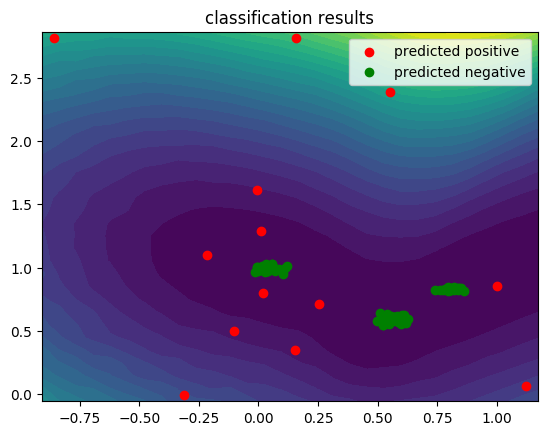

In [15]:
# plot it all
f = figure()
contourf(x, y, zz,30)
scatter(X[1, tryhat.==1], X[2, tryhat.==1], c = "r", 
    label = "predicted positive")
scatter(X[1, tryhat.==0], X[2, tryhat.==0], c = "g", 
    label = "predicted negative")
title("classification results")
xlim(xl)
ylim(yl)
legend()
show()

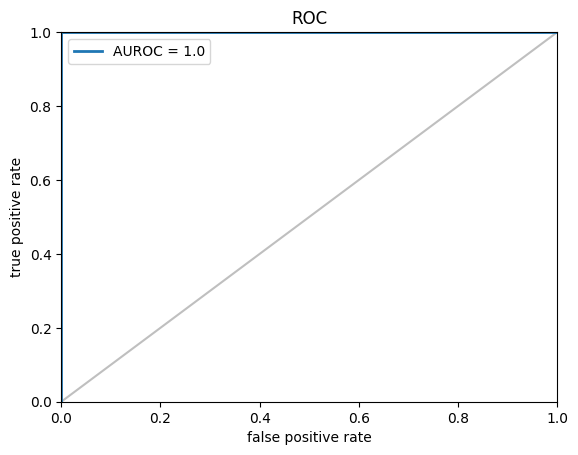

In [16]:
# plot ROC curve and compute AUROC score
ascore = AnomalyDetection.anomalyscore(model, X);
fprvec, tprvec = EvalCurves.roccurve(ascore, Y)
auroc = round(EvalCurves.auc(fprvec, tprvec),3)
EvalCurves.plotroc((fprvec, tprvec, "AUROC = $(auroc)"))
show()